Loading CSV from: CloudWatch_Traffic_Web_Attack.csv
Raw shape: (5000, 17)
Columns: ['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip', 'src_ip_country_code', 'protocol', 'response.code', 'dst_port', 'dst_ip', 'rule_names', 'observation_name', 'source.meta', 'source.name', 'time', 'detection_types', 'is_suspicious']

Using provided is_suspicious column (positives: 282 / 5000).

Top value counts for some helpful columns (first 10):

=== src_ip_country_code ===
src_ip_country_code
US    700
DE    633
CN    621
BR    608
     ... 
GB    570
FR    560
CA     72
AT     21
Name: count, Length: 10, dtype: int64

=== protocol ===
protocol
HTTPS    1491
SSH      1209
HTTP     1162
SMTP     1138
Name: count, dtype: int64

=== response_code ===
response_code
200    2623
301     815
500     809
404     753
Name: count, dtype: int64

=== dst_port ===
dst_port
443    1491
22     1209
80     1162
25     1138
Name: count, dtype: int64

=== source_name ===
source_name
prod_webserver    5000

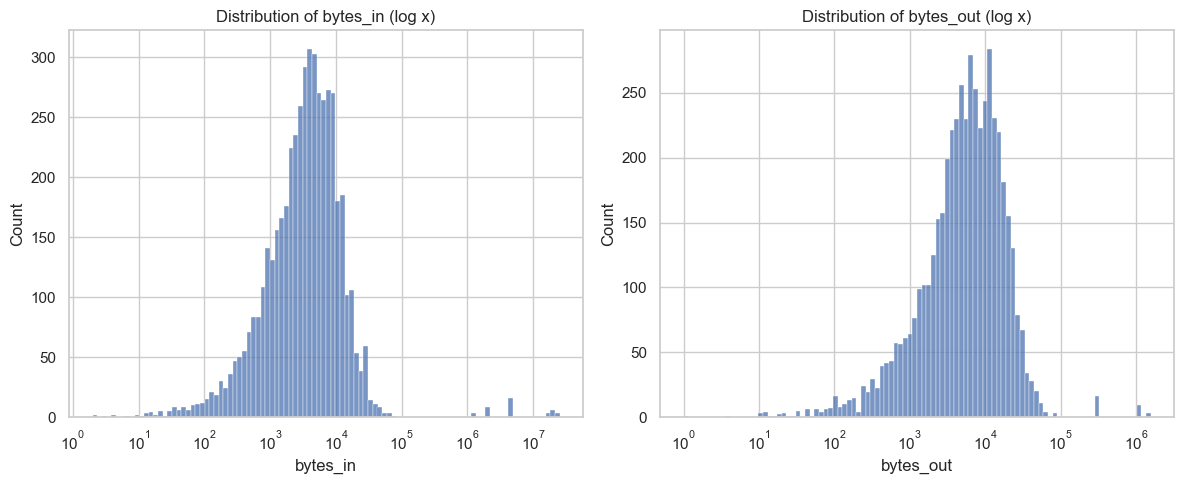

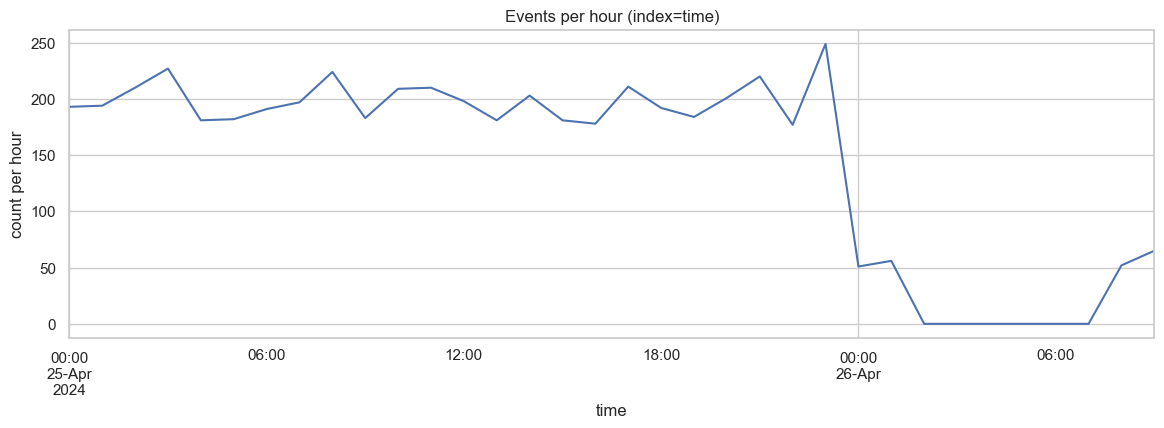

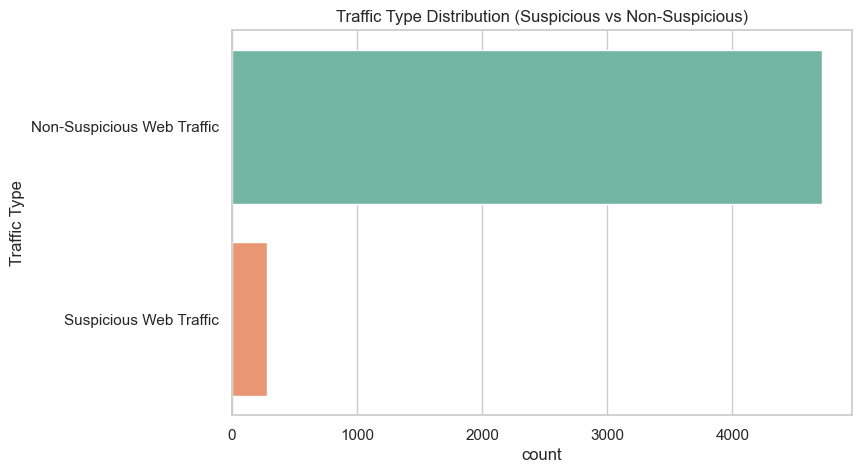

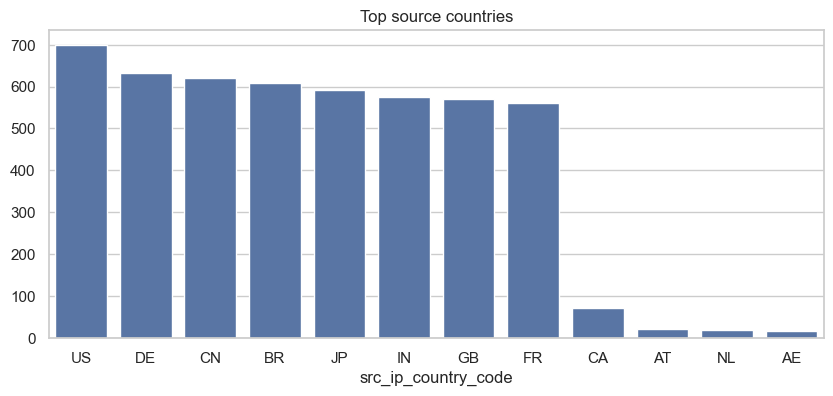

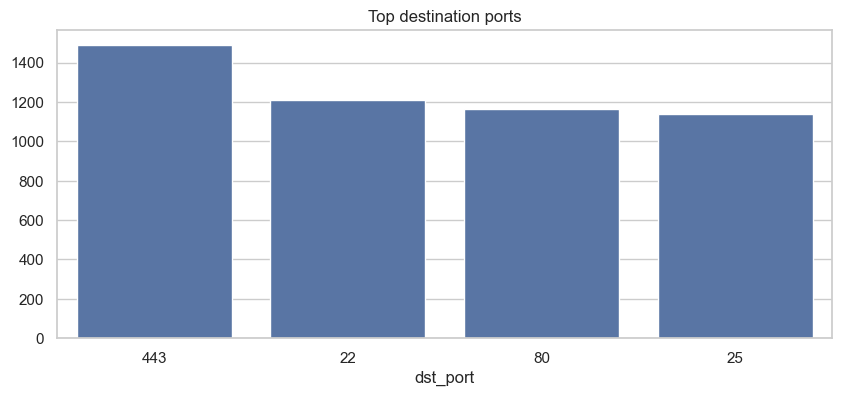

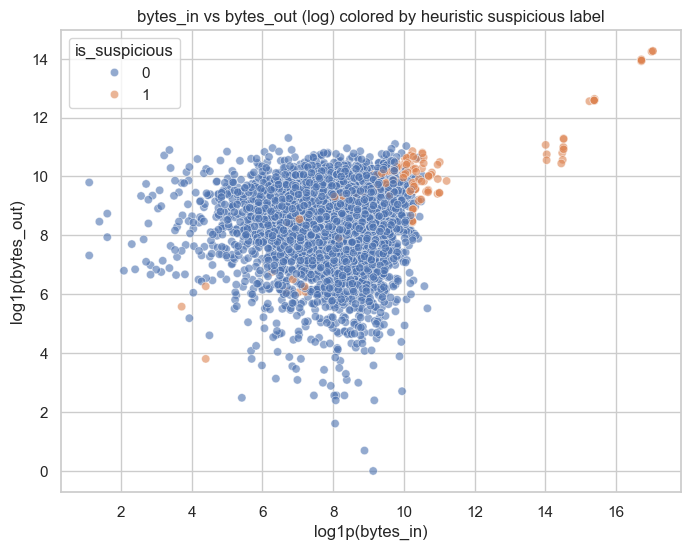


Feature engineering for anomaly detection & classification...
Numeric features used: ['bytes_in', 'bytes_out', 'duration_sec', 'dst_port', 'response_code', 'src_ip_request_count', 'src_ip_mean_bytes_in', 'src_ip_unique_dst_ports']


In [4]:
import xgboost
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")
%matplotlib inline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.decomposition import PCA

# ----------------------- Load data (tries multiple likely paths) -----------------------
possible_paths = [
    '/mnt/data/CloudWatch_Traffic_Web_Attack.csv',
    '/content/CloudWatch_Traffic_Web_Attack.csv',
    'CloudWatch_Traffic_Web_Attack.csv',
    '/content/drive/MyDrive/CloudWatch_Traffic_Web_Attack.csv'
]
data_path = None
for p in possible_paths:
    if os.path.exists(p):
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError(f"CSV not found. Checked paths: {possible_paths}\n"
                            "Please upload the file to Colab and re-run or adjust path.")
print(f"Loading CSV from: {data_path}")
df = pd.read_csv(data_path, low_memory=False)
print(f"Raw shape: {df.shape}")
print("Columns:", list(df.columns)[:30])

# ----------------------- Normalize column names -----------------------
df.columns = [c.strip().lower().replace(' ', '_').replace('.', '_') for c in df.columns]

# ----------------------- Basic type conversions & feature creation -----------------------
# parse likely timestamp columns
for tcol in ['creation_time', 'end_time', 'time']:
    if tcol in df.columns:
        df[tcol] = pd.to_datetime(df[tcol], errors='coerce')

# numeric conversions for bytes/ports/response codes
for ncol in ['bytes_in', 'bytes_out', 'dst_port', 'response_code', 'response_code']:  # response_code may exist with different name
    if ncol in df.columns:
        df[ncol] = pd.to_numeric(df[ncol], errors='coerce')

# duration
if ('creation_time' in df.columns) and ('end_time' in df.columns):
    df['duration_sec'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
else:
    df['duration_sec'] = np.nan

# fill strings for rule/detection/object observations
for s in ['rule_names', 'detection_types', 'observation_name', 'source_name', 'src_ip_country_code', 'protocol']:
    if s in df.columns:
        df[s] = df[s].fillna('').astype(str)

# ----------------------- Label: is_suspicious -----------------------
if "is_suspicious" in df.columns:
    # Already labeled (0/1), just enforce type
    df["is_suspicious"] = df["is_suspicious"].astype(int)
    print(f"\nUsing provided is_suspicious column (positives: {df['is_suspicious'].sum()} / {len(df)}).")
else:
    # Heuristic fallback
    suspicious_keywords = r"(suspicious|attack|malicious|bot|exploit|scanner|sqli|xss|rce|brute)"
    label_components = []
    if 'rule_names' in df.columns:
        label_components.append(df['rule_names'].str.strip() != '')
    if 'detection_types' in df.columns:
        label_components.append(df['detection_types'].str.strip() != '')
    if 'observation_name' in df.columns:
        label_components.append(df['observation_name'].str.lower().str.contains(suspicious_keywords, regex=True, na=False))
    if len(label_components) == 0:
        df['is_suspicious'] = 0
    else:
        df['is_suspicious'] = np.logical_or.reduce(label_components).astype(int)

    print("\nLabel heuristic applied:")
    print(" - Using fields present:", [c for c in ['rule_names','detection_types','observation_name'] if c in df.columns])
    print(f" - Suspicious rows (heuristic): {df['is_suspicious'].sum()} / {len(df)}  ({df['is_suspicious'].mean()*100:.2f}%)")

# ----------------------- Quick summary & top counts -----------------------
pd.set_option('display.max_rows', 8)
print("\nTop value counts for some helpful columns (first 10):")
for col in ['src_ip_country_code','protocol','response_code','dst_port','source_name']:
    if col in df.columns:
        print(f"\n=== {col} ===")
        print(df[col].value_counts(dropna=False).head(10))

# ----------------------- EDA Visualizations -----------------------
print("\nGenerating EDA visualizations...")
plt.figure(figsize=(12,5))
if 'bytes_in' in df.columns:
    ax = plt.subplot(1,2,1)
    sns.histplot(df['bytes_in'].dropna(), log_scale=(True,False), kde=False, bins=100)
    ax.set_title('Distribution of bytes_in (log x)')
if 'bytes_out' in df.columns:
    ax = plt.subplot(1,2,2)
    sns.histplot(df['bytes_out'].dropna(), log_scale=(True,False), kde=False, bins=100)
    ax.set_title('Distribution of bytes_out (log x)')
plt.tight_layout()
plt.show()

# time series of counts (if time available)
time_col = 'time' if 'time' in df.columns else ('creation_time' if 'creation_time' in df.columns else None)
if time_col:
    ts = df.set_index(time_col).resample('1H').size()
    plt.figure(figsize=(14,4))
    ts.plot()
    plt.title(f'Events per hour (index={time_col})')
    plt.ylabel('count per hour')
    plt.show()

if 'rule_names' in df.columns and 'is_suspicious' in df.columns:
    df['_rule_label'] = df['is_suspicious'].map({1: "Suspicious Web Traffic", 0: "Non-Suspicious Web Traffic"})
    top_rules = df['_rule_label'].value_counts().head(15)
    plt.figure(figsize=(8,5))
    sns.barplot(y=top_rules.index, x=top_rules.values, palette="Set2")
    plt.title('Traffic Type Distribution (Suspicious vs Non-Suspicious)')
    plt.xlabel('count')
    plt.ylabel('Traffic Type')
    plt.show()

if 'src_ip_country_code' in df.columns:
    plt.figure(figsize=(10,4))
    top_countries = df['src_ip_country_code'].value_counts().head(12)
    sns.barplot(x=top_countries.index, y=top_countries.values)
    plt.title('Top source countries')
    plt.show()

if 'dst_port' in df.columns:
    plt.figure(figsize=(10,4))
    top_ports = df['dst_port'].value_counts().head(12)
    sns.barplot(x=top_ports.index.astype(str), y=top_ports.values)
    plt.title('Top destination ports')
    plt.show()

# scatter bytes_in vs bytes_out colored by label (sample if huge)
if ('bytes_in' in df.columns) and ('bytes_out' in df.columns):
    sample = df.sample(n=min(5000, len(df)), random_state=42)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=np.log1p(sample['bytes_in']), y=np.log1p(sample['bytes_out']), hue=sample['is_suspicious'], alpha=0.6)
    plt.xlabel('log1p(bytes_in)')
    plt.ylabel('log1p(bytes_out)')
    plt.title('bytes_in vs bytes_out (log) colored by heuristic suspicious label')
    plt.legend(title='is_suspicious')
    plt.show()

# ----------------------- Feature engineering for models -----------------------
print("\nFeature engineering for anomaly detection & classification...")

# Convert some columns if present
for c in ['dst_port','response_code','duration_sec','bytes_in','bytes_out']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# aggregation features by src_ip (counts, avg bytes)
if 'src_ip' in df.columns:
    df['src_ip_request_count'] = df.groupby('src_ip')['src_ip'].transform('count')
    if 'bytes_in' in df.columns:
        df['src_ip_mean_bytes_in'] = df.groupby('src_ip')['bytes_in'].transform('mean').fillna(0)
    if 'dst_port' in df.columns:
        df['src_ip_unique_dst_ports'] = df.groupby('src_ip')['dst_port'].transform('nunique').fillna(0)

# pick numeric features for unsupervised anomaly detection
candidate_num = ['bytes_in','bytes_out','duration_sec','dst_port','response_code',
                 'src_ip_request_count','src_ip_mean_bytes_in','src_ip_unique_dst_ports']
num_features = [c for c in candidate_num if c in df.columns]
print("Numeric features used:", num_features)

# Fill na for numeric features
X_num = df[num_features].fillna(0).copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)


Training Isolation Forest for anomaly detection...
 - Contamination set to: 0.0564 (heuristic: fraction of labeled suspicious rows if available, clamped to (0,0.5])
Anomaly detection results vs provided/heuristic label:
              precision    recall  f1-score   support

           0      0.975     0.975     0.975      4718
           1      0.589     0.589     0.589       282

    accuracy                          0.954      5000
   macro avg      0.782     0.782     0.782      5000
weighted avg      0.954     0.954     0.954      5000

ROC AUC (anomaly score vs label): 0.9243
Average Precision (PR AUC): 0.6017


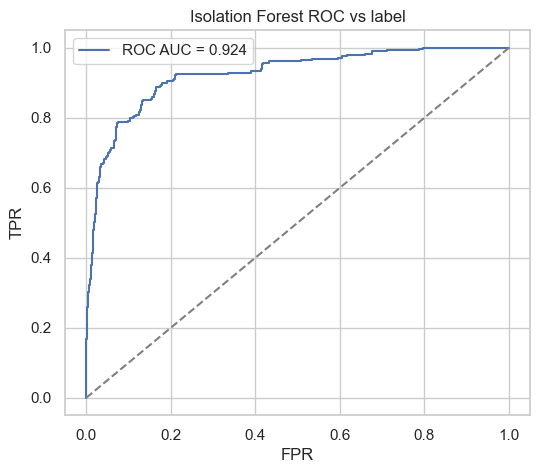


Top anomaly-score rows (head):
       src_ip       dst_ip  dst_port  bytes_in  bytes_out  response_code             rule_names detection_types  anomaly_score  is_suspicious
155.91.45.242 10.138.69.97       443  25207794    1561220            200 Suspicious Web Traffic        waf_rule       0.259450              1
155.91.45.242 10.138.69.97       443  25199191    1557598            200 Suspicious Web Traffic        waf_rule       0.259450              1
155.91.45.242 10.138.69.97       443  24326941    1529035            200 Suspicious Web Traffic        waf_rule       0.258887              1
155.91.45.242 10.138.69.97       443  18201558    1170896            200 Suspicious Web Traffic        waf_rule       0.254682              1
155.91.45.242 10.138.69.97       443  18187778    1142605            200 Suspicious Web Traffic        waf_rule       0.254682              1
155.91.45.242 10.138.69.97       443  18239056    1144663            200 Suspicious Web Traffic        waf_rule     

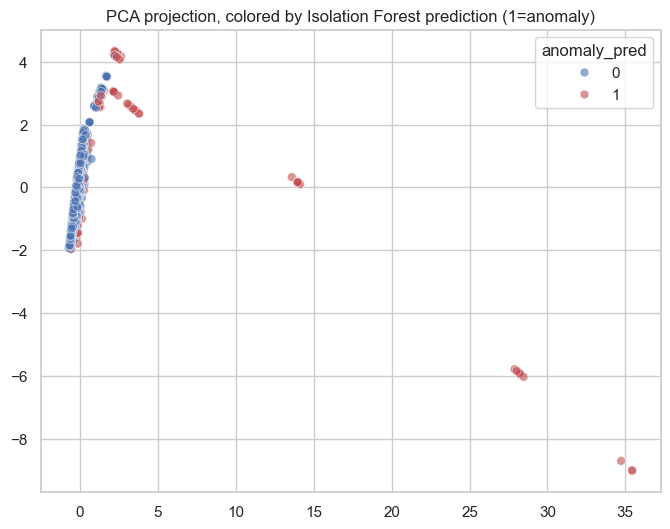

In [5]:
# ----------------------- Anomaly Detection: Isolation Forest -----------------------
print("\nTraining Isolation Forest for anomaly detection...")

# Estimate contamination from labels if available, else default small fraction
if "is_suspicious" in df.columns and df['is_suspicious'].sum() > 0:
    contamination_guess = df['is_suspicious'].mean()
else:
    contamination_guess = 0.01
contamination_guess = min(max(contamination_guess, 1e-4), 0.5)

print(f" - Contamination set to: {contamination_guess:.4f} "
      f"(heuristic: fraction of labeled suspicious rows if available, clamped to (0,0.5])")

iso = IsolationForest(
    n_estimators=200,
    contamination=float(contamination_guess),
    random_state=42
)
iso.fit(X_scaled)

# anomaly score: higher = more anomalous
df['anomaly_score'] = -iso.decision_function(X_scaled)
df['anomaly_pred'] = (iso.predict(X_scaled) == -1).astype(int)

# ----------------------- Evaluation -----------------------
if "is_suspicious" in df.columns and df['is_suspicious'].nunique() > 1:
    print("Anomaly detection results vs provided/heuristic label:")
    y_true = df['is_suspicious'].astype(int)
    y_pred = df['anomaly_pred']
    print(classification_report(y_true, y_pred, digits=3))

    auc = roc_auc_score(y_true, df['anomaly_score'])
    ap = average_precision_score(y_true, df['anomaly_score'])
    print(f"ROC AUC (anomaly score vs label): {auc:.4f}")
    print(f"Average Precision (PR AUC): {ap:.4f}")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, df['anomaly_score'])
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'ROC AUC = {auc:.3f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title('Isolation Forest ROC vs label')
    plt.legend(); plt.show()
else:
    print("No valid label distribution available; anomaly detection run unsupervised. "
          "Inspect top anomaly_score rows manually.")

# ----------------------- Inspect Top Anomalies -----------------------
display_cols = [c for c in [
    'src_ip','dst_ip','dst_port','bytes_in','bytes_out',
    'response_code','rule_names','detection_types',
    'anomaly_score','is_suspicious'
] if c in df.columns]

top_anom = df.sort_values('anomaly_score', ascending=False).head(10)
print("\nTop anomaly-score rows (head):")
print(top_anom[display_cols].to_string(index=False))

# ----------------------- Visualization: PCA -----------------------
if X_scaled.shape[1] >= 2:
    pca = PCA(n_components=2, random_state=42)
    proj = pca.fit_transform(X_scaled)
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=proj[:,0], y=proj[:,1],
        hue=df['anomaly_pred'], palette=['C0','C3'], alpha=0.6, s=40
    )
    plt.title('PCA projection, colored by Isolation Forest prediction (1=anomaly)')
    plt.show()



Supervised classification (Random Forest) to predict heuristic label (is_suspicious).
Features for classifier: ['bytes_in', 'bytes_out', 'duration_sec', 'dst_port', 'response_code', 'src_ip_request_count', 'src_ip_mean_bytes_in', 'src_ip_unique_dst_ports', 'protocol', 'src_ip_country_code', 'source_name_small']
Grouped split on src_ip: Train=(4006, 11), Test=(994, 11)
Fold 1: Balanced Acc=1.000, AUC=1.000 AP=1.000
Fold 2: Balanced Acc=0.982, AUC=1.000 AP=1.000
Fold 3: Balanced Acc=0.991, AUC=1.000 AP=1.000
Fold 4: Balanced Acc=1.000, AUC=1.000 AP=1.000
Fold 5: Balanced Acc=0.991, AUC=1.000 AP=1.000

--- Cross-validated performance ---
Balanced Accuracy: 0.993 ± 0.007
ROC AUC: 1.000 ± 0.000
PR AUC: 1.000 ± 0.000

Classification report (Random Forest, hold-out test):
              precision    recall  f1-score   support

           0     0.9958    1.0000    0.9979       944
           1     1.0000    0.9200    0.9583        50

    accuracy                         0.9960       994
   ma

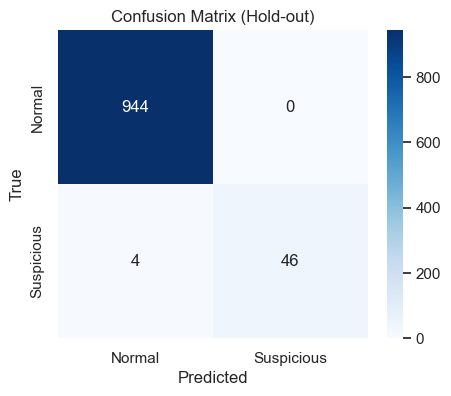


=== Extra Visualizations ===


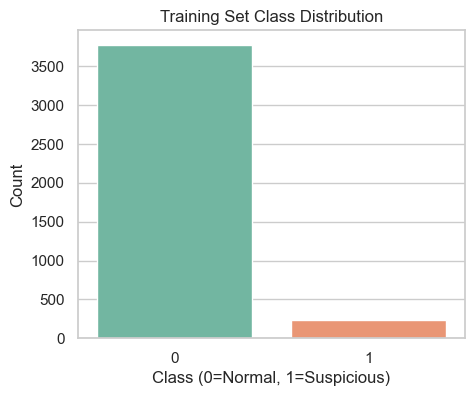

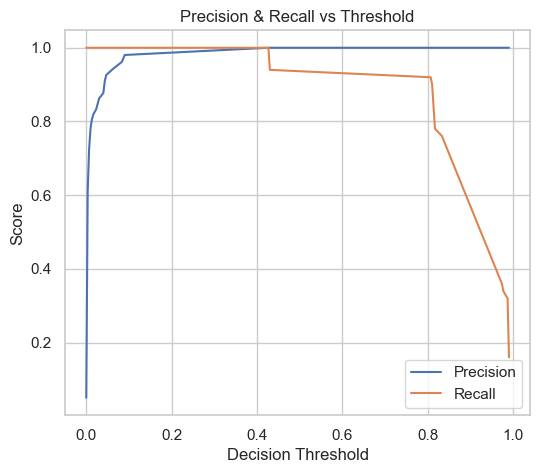

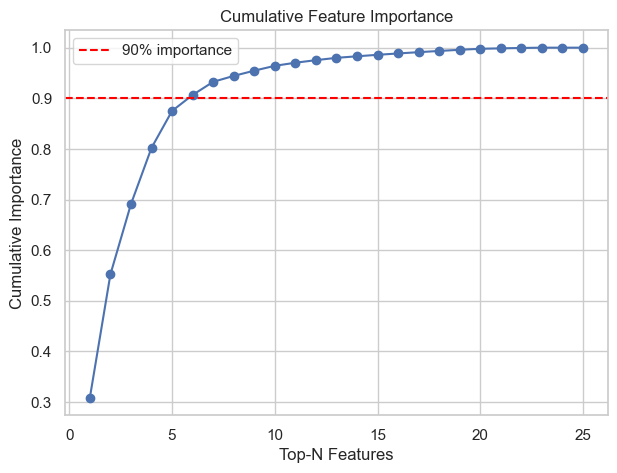

False negatives (missed suspicious cases): 4
Sample false negatives:


,bytes_in,bytes_out,duration_sec,dst_port,response_code,src_ip_request_count,src_ip_mean_bytes_in,src_ip_unique_dst_ports,protocol,src_ip_country_code,source_name_small
907,790,444,600.0,443,200,1,790.0,1,HTTPS,US,prod_webserver
981,1628,8980,600.0,443,200,1,1628.0,1,HTTPS,US,prod_webserver
1787,40,264,600.0,443,200,1,40.0,1,HTTPS,US,prod_webserver
2457,1112,430,600.0,443,200,1,1112.0,1,HTTPS,US,prod_webserver


In [6]:
# ----------------------- Classification: Supervised IDS Model -----------------------
print("\nSupervised classification (Random Forest) to predict heuristic label (is_suspicious).")

# enforce int labels early
df['is_suspicious'] = df['is_suspicious'].astype(int)

# Exclude columns that were used to CREATE the label (avoid leakage)
exclude_cols = {'rule_names','detection_types','observation_name','is_suspicious'}

# Candidate categorical features
cat_candidates = [c for c in ['protocol','src_ip_country_code','source_name']
                  if c in df.columns and c not in exclude_cols]

# Reduce high-cardinality source_name
if 'source_name' in cat_candidates:
    topk = 20
    top_names = df['source_name'].value_counts().nlargest(topk).index.tolist()
    df['source_name_small'] = df['source_name'].where(df['source_name'].isin(top_names), '__OTHER__')
    cat_candidates = [c if c != 'source_name' else 'source_name_small' for c in cat_candidates]

# Final feature list
features_for_clf = [c for c in (num_features + cat_candidates) if c not in exclude_cols and c in df.columns]
print("Features for classifier:", features_for_clf)

X = df[features_for_clf].copy()
y = df['is_suspicious']

num_cols = [c for c in features_for_clf if c in num_features]
cat_cols = [c for c in features_for_clf if c not in num_cols]

if len(np.unique(y)) < 2:
    print("Only one class present → cannot train classifier.")
else:
    # ---------- Grouped split to avoid leakage ----------
    group_col = 'src_ip' if 'src_ip' in df.columns else (
                'source_name_small' if 'source_name_small' in df.columns else None)
    if group_col is not None:
        from sklearn.model_selection import GroupShuffleSplit
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        train_idx, test_idx = next(gss.split(X, y, groups=df[group_col]))
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        print(f"Grouped split on {group_col}: Train={X_train.shape}, Test={X_test.shape}")
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, stratify=y, test_size=0.2, random_state=42
        )
        print("Standard stratified split:", X_train.shape, X_test.shape)

    # ---------- Noise injection for robustness ----------
    def add_noise(df_in, noise_level=0.01):
        df_out = df_in.copy()
        for col in num_cols:
            if col in df_out.columns:
                std = df_out[col].std()
                if std > 0:
                    df_out[col] += np.random.normal(0, noise_level * std, size=len(df_out))
        return df_out

    X_train = add_noise(X_train)

    # ---------- Preprocessor ----------
    import inspect
    transformers = []
    if num_cols:
        transformers.append(('num', StandardScaler(), num_cols))
    if cat_cols:
        if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
            ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        else:
            ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        transformers.append(('cat', ohe, cat_cols))
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

    # ---------- Classifier ----------
    clf = Pipeline([
        ('pre', preprocessor),
        ('rf', RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            class_weight='balanced_subsample',
            random_state=42,
            n_jobs=-1
        ))
    ])

    # ---------- Cross-validation with grouped folds ----------
    from sklearn.model_selection import GroupKFold, StratifiedKFold
    from sklearn.metrics import balanced_accuracy_score

    if group_col is not None:
        cv = GroupKFold(n_splits=5)
        cv_split = cv.split(X, y, groups=df[group_col])
    else:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_split = cv.split(X, y)

    bal_accs, aucs, aps = [], [], []

    for fold, (train_idx, val_idx) in enumerate(cv_split, 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_tr = add_noise(X_tr)  # noise per fold

        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        y_proba = clf.predict_proba(X_val)[:,1] if len(clf.classes_)==2 else None

        ba = balanced_accuracy_score(y_val, y_pred)
        bal_accs.append(ba)

        if y_proba is not None:
            aucs.append(roc_auc_score(y_val, y_proba))
            aps.append(average_precision_score(y_val, y_proba))

        print(f"Fold {fold}: Balanced Acc={ba:.3f}, "
              f"AUC={roc_auc_score(y_val, y_proba):.3f} "
              f"AP={average_precision_score(y_val, y_proba):.3f}")

    print("\n--- Cross-validated performance ---")
    print(f"Balanced Accuracy: {np.mean(bal_accs):.3f} ± {np.std(bal_accs):.3f}")
    if aucs: print(f"ROC AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    if aps: print(f"PR AUC: {np.mean(aps):.3f} ± {np.std(aps):.3f}")

    # ---------- Final fit on train/test (for inspection) ----------
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1] if len(clf.classes_)==2 else None

    print("\nClassification report (Random Forest, hold-out test):")
    print(classification_report(y_test, y_pred, digits=4))
    print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_test, y_proba))
        print("PR AUC (avg precision):", average_precision_score(y_test, y_proba))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal','Suspicious'],
                yticklabels=['Normal','Suspicious'])
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (Hold-out)')
    plt.show()

   # ----------------------- Extra Visualizations for Classification -----------------------
print("\n=== Extra Visualizations ===")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

# 1. Class balance in training set
plt.figure(figsize=(5,4))
sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts().values, palette="Set2")
plt.title("Training Set Class Distribution")
plt.xlabel("Class (0=Normal, 1=Suspicious)")
plt.ylabel("Count")
plt.show()

# 3. Precision-Recall vs threshold
if y_proba is not None:
    prec, rec, thresh = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(thresh, prec[:-1], label="Precision")
    plt.plot(thresh, rec[:-1], label="Recall")
    plt.xlabel("Decision Threshold"); plt.ylabel("Score")
    plt.title("Precision & Recall vs Threshold")
    plt.legend(); plt.show()

# 4. Cumulative Feature Importance
try:
    importances = clf.named_steps['rf'].feature_importances_
    feature_names = []
    if num_cols:
        feature_names.extend(num_cols)
    if cat_cols:
        ohe = clf.named_steps['pre'].named_transformers_['cat']
        cat_names = ohe.get_feature_names_out(cat_cols) if hasattr(ohe, "get_feature_names_out") \
                    else ohe.get_feature_names(cat_cols)
        feature_names.extend(list(cat_names))
    sorted_idx = np.argsort(importances)[::-1]
    cum_importance = np.cumsum(importances[sorted_idx])
    plt.figure(figsize=(7,5))
    plt.plot(range(1, len(importances)+1), cum_importance, marker="o")
    plt.axhline(0.9, color="red", linestyle="--", label="90% importance")
    plt.xlabel("Top-N Features")
    plt.ylabel("Cumulative Importance")
    plt.title("Cumulative Feature Importance")
    plt.legend(); plt.show()
except Exception as e:
    print("Feature importance plotting skipped:", e)

# 5. Misclassification analysis (false negatives)
errors = X_test[(y_test==1) & (y_pred==0)]
print(f"False negatives (missed suspicious cases): {errors.shape[0]}")
if not errors.empty:
    print("Sample false negatives:")
    display(errors.head(10))

